In [18]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.stats import gamma, halfnorm
import corner
import emcee

In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("SEOB_4D_MM_data.txt",names = columns)
datatab

,x,y,z,w,data,error
0,0.1,-1.439897,0.0,0.25,-2.831628,0.815517
1,0.1,-1.308997,0.5,0.25,-3.006489,0.926090
2,0.1,-1.178097,1.0,0.25,-2.354835,0.699513
3,0.1,-1.047198,1.0,0.25,-2.974002,0.712574
4,0.1,-0.916298,1.0,0.25,-2.401510,0.699986
...,...,...,...,...,...,...
995,0.7,1.570796,-1.0,1.00,-2.287634,0.687055
996,0.8,1.570796,-1.0,1.00,-2.164392,0.692650
997,0.9,1.570796,-1.0,1.00,-2.152368,0.693543
998,1.0,-1.439897,-1.0,1.00,-2.579505,1.226236


In [3]:
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

In [4]:
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test = train_test_split(X1, dm1.reshape(-1,1), train_size=0.8, random_state=1)

In [5]:
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test = train_test_split(X2, dm2.reshape(-1,1), train_size=0.8, random_state=3)

In [6]:
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test = train_test_split(X3, dm3.reshape(-1,1), train_size=0.8, random_state=5)

In [7]:
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test = train_test_split(X4, dm4.reshape(-1,1), train_size=0.8, random_state=7)

In [8]:
X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#print(D_test.shape,D_train.shape,X_test.shape,X_train.shape)

In [9]:
X = np.column_stack((x, y, z, w))
D = data.to_numpy().reshape(-1,1)

#guess_l = (1., 1., 1., 1.)
#bounds_l = ((1e-20, 4.),) * 4
guess_l = 1
bounds_l = (1e-20, 4.)
guess_n = 1.
bounds_n = (1e-20, 1.)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

kernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
         RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Fitted Kernel: 1.13**2 * RBF(length_scale=0.665) + WhiteKernel(noise_level=0.129)


In [10]:
print("gpr.kernel_:", gpr.kernel_.theta)

gpr.kernel_: [ 0.25023191 -0.40772898 -2.04619221]


In [11]:
Dfit1, Dstd1 = gpr.predict(X1, return_std=True)
Dfit2, Dstd2 = gpr.predict(X2, return_std=True)
Dfit3, Dstd3 = gpr.predict(X3, return_std=True)
Dfit4, Dstd4 = gpr.predict(X4, return_std=True)

In [22]:
def log_prior(theta):
    #l1, l2, l3, l4, sigma, sigma_n = theta
    l1,sigma, sigma_n = theta
    # All must be positive.
    #if l1 <= 0 or l2 <= 0 or l3 <= 0 or l4 <= 0 or sigma <= 0 or sigma_n <= 0:
    if l1<=0 or sigma <= 0 or sigma_n <= 0:
        return -np.inf
    logp_l1 = gamma(a=1.25, scale=1).logpdf(l1)
    #logp_l2 = gamma(a=1.5, scale=1).logpdf(l2)
    #logp_l3 = gamma(a=2, scale=1).logpdf(l3)
    #logp_l4 = gamma(a=2, scale=1).logpdf(l4)
    logp_sigma = gamma(a=2, scale=1).logpdf(sigma)
    logp_sigma_n = halfnorm(scale=1).logpdf(sigma_n)
    #log_jacobian = np.sum(theta)
    #logptrue =  logp_l1 + logp_l2 + logp_l3 + logp_l4 + logp_sigma + logp_sigma_n
    logptrue = logp_l1 + logp_sigma + logp_sigma_n
    return logptrue

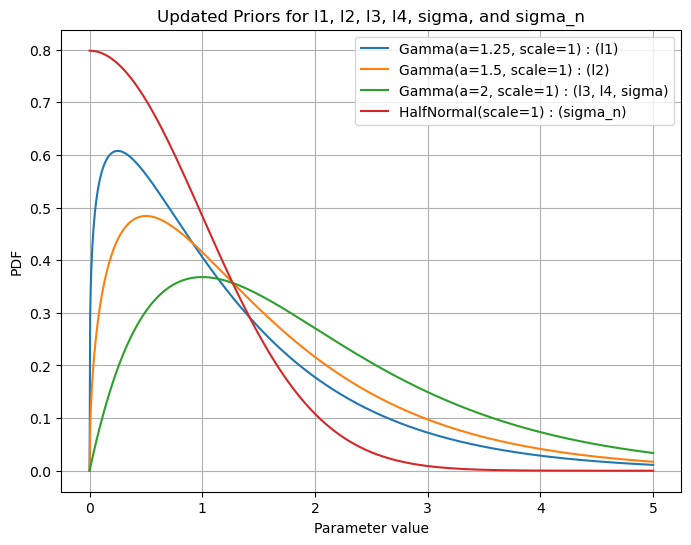

In [24]:
x = np.linspace(0, 5, 1000)

pdf_gamma_125 = gamma(a=1.25, scale=1).pdf(x)
pdf_gamma_15  = gamma(a=1.5, scale=1).pdf(x)
pdf_gamma_2   = gamma(a=2, scale=1).pdf(x)

pdf_halfnorm = halfnorm(scale=1).pdf(x)

plt.figure(figsize=(8, 6))
plt.plot(x, pdf_gamma_125, label="Gamma(a=1.25, scale=1) : (l1)")
plt.plot(x, pdf_gamma_15,  label="Gamma(a=1.5, scale=1) : (l2)")
plt.plot(x, pdf_gamma_2,   label="Gamma(a=2, scale=1) : (l3, l4, sigma)")
plt.plot(x, pdf_halfnorm,  label="HalfNormal(scale=1) : (sigma_n)")

plt.xlabel("Parameter value")
plt.ylabel("PDF")
plt.title("Updated Priors for l1, l2, l3, l4, sigma, and sigma_n")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = gpr.log_marginal_likelihood(theta)
    return lp + ll

In [38]:
ndim = 3
nwalkers = 300
initial_pos = gpr.kernel_.theta + 1e-1 * np.random.randn(nwalkers, ndim)

# Set up the emcee sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run the MCMC sampler for nsteps
nsteps = 20000
print("Running MCMC...")
sampler.run_mcmc(initial_pos, nsteps, progress=True)

# Discard some burn-in and thin the chain.
burnin = 200
thin = 10
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("Shape of the posterior samples:", samples.shape)

Running MCMC...


  0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [00:54<00:00, 365.92it/s]

Shape of the posterior samples: (594000, 3)


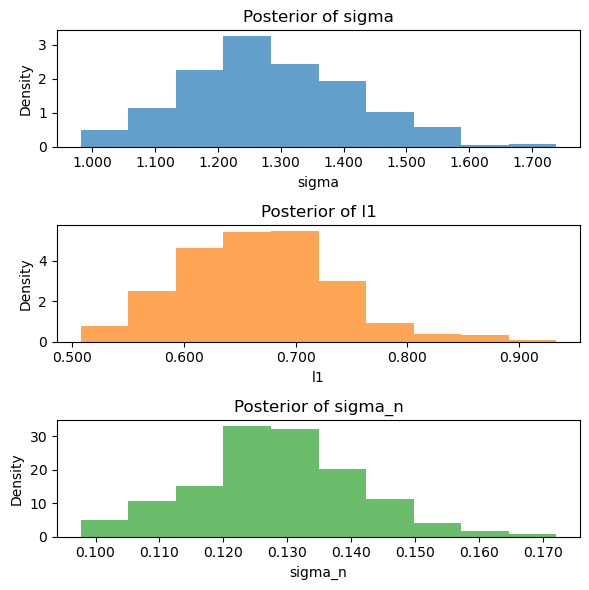

In [40]:
# Plot distributions
true_samples = np.exp(samples)
#labels = ["sigma","l1", "l2", "l3", "l4", "sigma_n"]
labels = ["sigma","l1", "sigma_n"]
fig, axes = plt.subplots(ndim, 1, figsize=(6, 2 * ndim))
for i in range(ndim):
    axes[i].hist(true_samples[:, i], bins=10, density=True, alpha=0.7, color='C{}'.format(i))
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Density")
    axes[i].set_title("Posterior of " + labels[i])
    axes[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.tight_layout()
plt.show()

In [42]:
# Compute the mean for each hyperparameter (along the sample axis)
mean_values = np.mean(true_samples, axis=0)
std_values = np.std(true_samples, axis=0)

# Compute the 2.5th and 97.5th percentiles for a 95% credible interval.
# This returns an array with shape (2, ndim) where the first row is the lower bound and the second is the upper bound.
ci_bounds = np.percentile(true_samples, [2.5, 97.5], axis=0)

# Print the results for each parameter
labels = [ "sigma","l1", "sigma_n"]
for i, label in enumerate(labels):
    print(f"{label}: mean = {mean_values[i]:.4f}, std = {std_values[i]:.4f}, 95% CI = [{ci_bounds[0, i]:.4f}, {ci_bounds[1, i]:.4f}]")

sigma: mean = 1.2845, std = 0.1351, 95% CI = [1.0116, 1.5758]
l1: mean = 0.6680, std = 0.0688, 95% CI = [0.5425, 0.8222]
sigma_n: mean = 0.1282, std = 0.0129, 95% CI = [0.1024, 0.1565]
